Importing Libraries

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns

Preparing the Data

In [2]:
img_height, img_width = 128, 128
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    'balanced_dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

test_generator = datagen.flow_from_directory(
    'balanced_dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

#saving the class labels
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)



Found 2723 images belonging to 2 classes.
Found 679 images belonging to 2 classes.


In [3]:
def get_data_from_generator(generator):
    x_data = []
    y_data = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        x_data.append(x_batch)
        y_data.append(y_batch)
    return np.vstack(x_data), np.vstack(y_data)

train_x, train_y = get_data_from_generator(train_generator)
test_x, test_y = get_data_from_generator(test_generator)

np.savez('train_data.npz', x=train_x, y=train_y)
np.savez('test_data.npz', x=test_x, y=test_y)


Importing the Data

In [4]:
train_data = np.load('train_data.npz')
x1 = train_data['x']
y1 = train_data['y']

test_data = np.load('test_data.npz')
x2 =test_data['x']
y2 = test_data['y']

print("Train Data Size:")
print(x1.shape)
print(y1.shape)

print("Test Data Size:")
print(x2.shape)
print(y2.shape)

with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)

print("\nNumber of classes:", y1.shape[1])
print(class_indices)


Train Data Size:
(2723, 128, 128, 3)
(2723, 2)
Test Data Size:
(679, 128, 128, 3)
(679, 2)

Number of classes: 2
{'non-recyclable': 0, 'recyclable': 1}


Visualizing the Dataset

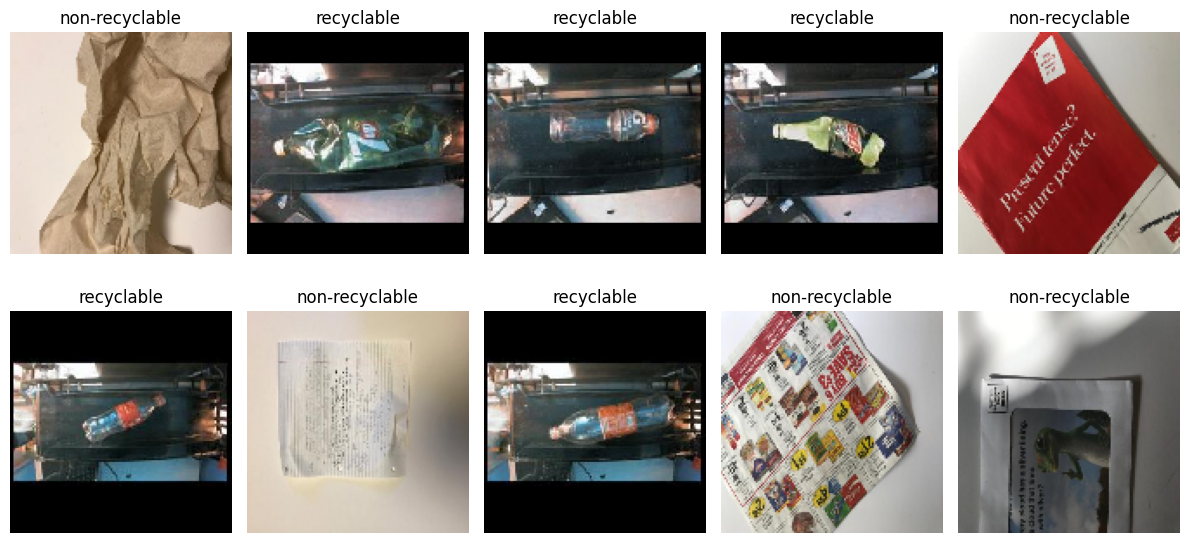

In [5]:
class_map = {0: 'non-recyclable', 1: 'recyclable'}

plt.figure(figsize=(12, 6))
for i in range(10):
    idx = np.random.randint(0, len(x1))
    image = x1[idx]
    label_index = np.argmax(y1[idx])
    label_name = class_map[label_index]

    plt.subplot(2, 5, i + 1)
    plt.imshow(image.squeeze(), cmap='gray' if image.shape[-1] == 1 else None)
    plt.title(label_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

Training Model

In [6]:
train_x, test_x, train_y, test_y = train_test_split(x1, y1,test_size=0.2,random_state = 0)

model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),     #number of filters = 32, filter size = 3x3
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),         #turns the 2D array to 1D array
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

 
MCP = ModelCheckpoint('Best_points.keras',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
#saves the best model i.e. the model with the highest val_accuracy

ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
#prevents the model from overfitting by stopping the training if there's no improvement in the val_accuracy

RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)
#improves the learning rate if the val_loss isn't improving

history = model.fit(train_x,train_y,epochs=10,validation_data=(test_x,test_y),callbacks=[MCP,ES,RLP])  
#using call backs prevents overfitting of the model

c:\Users\Moiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8095 - loss: 0.8243
Epoch 1: val_accuracy improved from -inf to 0.97431, saving model to Best_points.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.8109 - loss: 0.8175 - val_accuracy: 0.9743 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9754 - loss: 0.0985
Epoch 2: val_accuracy improved from 0.97431 to 0.97615, saving model to Best_points.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.9754 - loss: 0.0985 - val_accuracy: 0.9761 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9868 - loss: 0.0587
Epoch 3: val_accuracy did not improve from 0.97615
69/69 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9867 - loss: 0.0588 - val_accuracy: 0.9761 - val_loss: 0.1131 - learning_rate: 0.0010
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9797 - loss: 0.0732
Epoch 4: val_accurac

Plotting the metrics graph

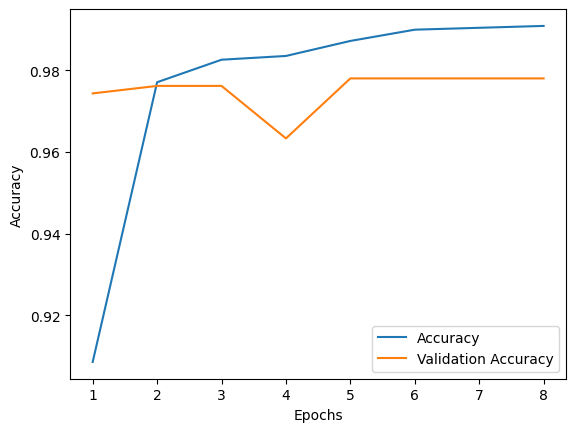

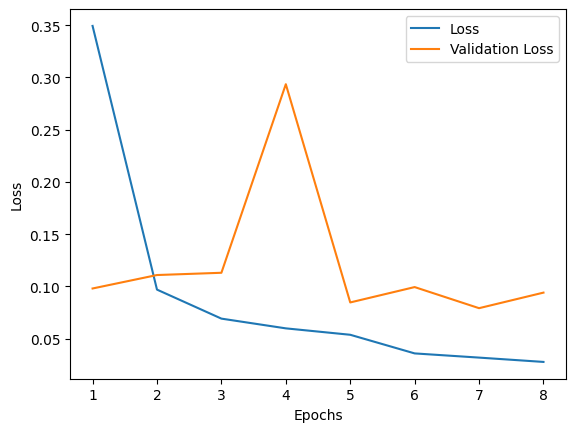

In [7]:
q = len(history.history['accuracy'])

sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

sns.lineplot(x = range(1,1+q),y = history.history['loss'], label='Loss')
sns.lineplot(x = range(1,1+q),y = history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Testing the Model

In [9]:
from tensorflow.keras.models import load_model

model = load_model("Best_points.keras")

test_loss, test_accuracy = model.evaluate(x2, y2)

print('Test Loss: ',test_loss)
print('Test Accuracy: ', test_accuracy)

train_loss, train_accuracy = model.evaluate(x1, y1)

print('Test Loss: ',train_loss)
print('Test Accuracy: ', train_accuracy)


22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 564ms/step - accuracy: 0.9746 - loss: 0.0760
Test Loss:  0.07833746075630188
Test Accuracy:  0.9749631881713867
86/86 ━━━━━━━━━━━━━━━━━━━━ 50s 576ms/step - accuracy: 0.9875 - loss: 0.0460
Test Loss:  0.04353795573115349
Test Accuracy:  0.9864120483398438
